# Turbulence EDA and Pre-Processing (all PIREPs)

## Why Turbulence?
Air travel is a major component of day-to-day life in the United States, and even across the world. Weather plays a very large role in air travel as many different factors come into play, such as visibility, icing, turbulence, and much more. At this time, we will be focusing on turbulence. 

Turbulence is "irregular motion of the air resulting from eddies and vertical currents" and "is one of the most unpredictable of all the weather phenomena that are of significance to pilots" (source: https://www.weather.gov/source/zhu/ZHU_Training_Page/turbulence_stuff/turbulence/turbulence.htm). Essentially, it is violent or unsteady movement of air or some other fluid.

## What Causes Turbulence?
Turbulence can be caused by a variety of different things, such as convection, mountains or uneven terrain, frontal passages, wind shear, and more. You can also have what's called clear air turbulence (CAT), which is not associated with clear atmospheric signs, such as cumuliform clouds. 

(source: https://www.weather.gov/source/zhu/ZHU_Training_Page/turbulence_stuff/turbulence/turbulence.htm).


## Data Used
For this demo, I am using pilot reports (PIREPs) to help determine if there is turbulence in an area. 

Pilot reports are sort of similar to ground-reports (like METARs), except up in the atmosphere. These serve as a way for the pilot to relay what they are actually experiencing in flight. A good bit of useful information about the weather can be included in these.

Data provided within the downloaded PIREPs: date/time, urgent, raw PIREP, icing, turbulence, lat/lon, aircraft, ATRCC
- Example PIREP: BNA UA /OV BNA135020/TM 1932/FL070/TP LJ60/TB MOD-SEV DURGD 070
    - Decoded: BNA - Nashville | UA - routine report | OV BNA135020 - relative location, 20 miles SE of BNA  | TM 1932 - time | FL 070 - altitude, 7000ft | TP LJ60 - aircraft | TB MOD-SEV - moderate to severe turbulence, DURGD 070 during decent 7000ft
    - They can include more information than this, including sky cover, icing, temperature, and other remarks

## Turbulence and the FM
With these reports layered on top of atmopsheric variables, the model can be trained to help identify areas where there could be potential turbulence.


## Notebook Contents:
For organizational purposes, this notebook will consist of both the EDA and pre-processing. Another notebook will contain information using MODG, based on this paper here: [insert link to paper]

Contents of this notebook:
    - Packages imported and installed
    - Downloading the data
    - Flight levels
    - Basic visualizations
        - PIREP points, PIREPs gridded, ArcMap with turbulence and major airports
    - Levels of turbulence
    - Downloads

## Importing and Installing Packages

A list of all packages that will be needed for the notebook.

In [1]:
!pip install -q geopandas
!pip install -q cartopy

import geopandas as gpd
import os
from pathlib import Path
import pandas as pd
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np

In [2]:
path = './pirep_downloads/'

df = pd.read_csv(path + 'all_pireps.csv', dtype = str, usecols = ['VALID', 'REPORT', 'TURBULENCE', 'LAT', 'LON'])
total_num = len(df)
print("Data points:", total_num)

Data points: 2824632


Thousands of PIREPs are issued daily and the data will constantly change. The output from the cell above tells us how many PIREPs are currently downloaded. Note that because there are so many data points, it may take a little extra time to run cells.

Before moving forward, let's take a look at our data frame.

Everything looks good to start out, but we'll add a "DateTime" column to make future filtering easier than using the "VALID" string.

In [4]:
valid = df['VALID']
datetimes = []

# datetime
from datetime import datetime

# input timestamp
for i in valid:
    timestamp_string = i

    # converting timestamp string to datetime object and formatting it
    datetime_object = datetime.strptime(timestamp_string,'%Y%m%d%H%M')
    #print(datetime_object)

    # append to list
    datetimes.append(datetime_object)

# append new column to df and check to make sure it's correct
df['DateTime'] = ''
df['DateTime']= datetimes
df[1:10]

,VALID,REPORT,TURBULENCE,LAT,LON,DateTime
1,201903010000,LFT UA /OV LFT180020 /TM 0000 /FL140 /TP E145 ...,NaN,29.87813966663967,-91.981,2019-03-01 00:00:00
2,201903010000,LFT UA /OV LFT180020 /TM 0000 /FL140 /TP E145 ...,NaN,29.87813966663967,-91.981,2019-03-01 00:00:00
3,201903010000,CLL UA /OV CLL /TM 0000 /FL250 /TP B737 /TB MO...,MOD CHOP 250-210,30.58806,-96.36389,2019-03-01 00:00:00
4,201903010000,CLL UA /OV CLL /TM 0000 /FL250 /TP B737 /TB MO...,MOD CHOP 250-210,30.58806,-96.36389,2019-03-01 00:00:00
5,201903010000,SAT UA /OV KERV /TM 0000 /FL021 /TP UNKN /SK B...,NaN,29.97667,-99.08547,2019-03-01 00:00:00
6,201903010000,SAT UA /OV KERV /TM 0000 /FL021 /TP UNKN /SK B...,NaN,29.97667,-99.08547,2019-03-01 00:00:00
7,201903010000,JHM UA /OV CHAIN/TM 0000/FL049/TP C208/SK SCT0...,NaN,35.03528,-85.20381,2019-03-01 00:00:00
8,201903010000,CSG UA /OV CSG 050010/TM 0000/FL45/TP E545/SK ...,NaN,32.623249945922495,-84.79079885750748,2019-03-01 00:00:00
9,201903010001,CNO UA /OV CNO/TM 0001/FL025/TP C172/TB NEG/RM...,NEG,33.97528,-117.63611,2019-03-01 00:01:00


## Data Visualization
### 1. The basics

Data used:
- Archived data from Iowa State University: https://mesonet.agron.iastate.edu/request/gis/pireps.php
- Shapefile for state outlines from census.gov (https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=States+%28and+equivalent%29)

Pulling in our PIREP (pilot report) data - these are raw reports from pilots. For visualization purposes, we'll use a shapefile for this section. Let's pull one hour worth of data from January 1st, 2023 (1200-1300).

In [5]:
pireps_vis = gpd.read_file("https://mesonet.agron.iastate.edu/cgi-bin/request/gis/pireps.py?year1=2023&month1=1&day1=1&hour1=12&minute1=0&year2=2023&month2=1&day2=1&hour2=13&minute2=0&fmt=shapefile.shp", include_fields = ['VALID','REPORT','TURB', 'LAT', 'LON'])
print(pireps_vis)

            VALID                                             REPORT  \
0    202301011200  GCK UA /OV GCK/TM 1200/FL350/TP B77/L/TB LGT/R...   
1    202301011200  ATL UA /OV RWY 9R/TM 1200/FLDURD/TP B739/SK BA...   
2    202301011200  ATL UA /OV RWY 9R/TM 1200/FLDURD/TP B739/SK BA...   
3    202301011200  BET UA /OV BET049052/TM 1200/FL330/TP B744/TB ...   
4    202301011201  OCF UA /OV OCF/TM 1201/FL003/TP GLF4/SK OVC001...   
..            ...                                                ...   
163  202301011258  OKC UA /OV IRW325043 /TM 1258 /FL250 /TP A321 ...   
164  202301011258  OKC UA /OV IRW325043 /TM 1258 /FL250 /TP A321 ...   
165  202301011258  CWA UA /OV CWA/TM 1258/FL028/TP CRJ2/SK BASE 0...   
166  202301011259        BBB UA /OV BBB/TM 1259/FL350/TP B77W/TB NEG   
167  202301011259   BCK UA /OV BCK/TM 1259/FL200/TP CRJ9/TB LGT CHOP   

                  TURB      LAT       LON                     geometry  
0                  LGT  37.9275 -100.7244  POINT (-100.72442 3

#### Plotting the PIREP points 
Plot of the pirep points from above.
For state boundaries, I downloaded the shapefile from census.gov.

In [135]:
# fix
# states = gpd.read_file('tl_2022_us_state.shp')

# non_continental = ['HI','VI','MP','GU','AK','AS','PR']
# us49 = states
# for n in non_continental:
#     us49 = us49[us49.STUSPS != n]

# points_clip = gpd.clip(pireps_vis, us49)

# points_clip = points_clip.to_crs(us49.crs)

# base = us49.boundary.plot()
# points_clip.plot(ax=base, marker='*', color='black', markersize=8)

## Filtering, Stats, and more Visualizations

## Flight Levels

Before we go into the analysis, we are going to filter through the flight levels first, and use the reamining data points for the rest of the analysis. First, let's pull the flight level out of the report string. If flight levels have a range (110-130 for example), then an average will be taken.

Reports without a valid flight level (like "DURD" for example) will be assigned values of -1.

Note: flight levels are in values of 100 (001 = 100 feet, 250 = 25,000 feet and so on). They are also MSL.

In [6]:
# pull the FL from the report string
reports = df['REPORT']

flight_levels = []
letters = ""
fl = ""
res = []

for x in reports:
    split = x.split("/", 4)[3]
    flight_levels.append(split)
    
flight_levels[:5]
#print(len(flight_levels))

['FL035', 'FL140 ', 'FL140 ', 'FL250 ', 'FL250 ']

In [8]:
fl_num = []
avg_fl = []

for i in flight_levels:
    #removing FL from the string
    fl_rem = i.replace('FL', '')

    #average reports with a range. If conversion can't be made and average isn't taken, make -1 (some strings will also say things like SFC-090 or have other strings)
    if "-" in fl_rem:
        try: 
            s = fl_rem.split('-')
            result = (int(s[0]) + int(s[1]))//2
            avg_fl.append(result)
        except ValueError:
            other_num = -1
            avg_fl.append(other_num)
    elif "-" not in fl_rem:
    #convert everything else to integers -- if it can't convert to an integer, make it 0
        try:
            result = int(fl_rem)
        except ValueError:
            result = -1
        #print(result)
        fl_num.append(result)

df['FlightLevels'] = ''
df['FlightLevels'] = fl_num + avg_fl
df[1:10]

,VALID,REPORT,TURBULENCE,LAT,LON,DateTime,FlightLevels
1,201903010000,LFT UA /OV LFT180020 /TM 0000 /FL140 /TP E145 ...,NaN,29.87813966663967,-91.981,2019-03-01 00:00:00,140
2,201903010000,LFT UA /OV LFT180020 /TM 0000 /FL140 /TP E145 ...,NaN,29.87813966663967,-91.981,2019-03-01 00:00:00,140
3,201903010000,CLL UA /OV CLL /TM 0000 /FL250 /TP B737 /TB MO...,MOD CHOP 250-210,30.58806,-96.36389,2019-03-01 00:00:00,250
4,201903010000,CLL UA /OV CLL /TM 0000 /FL250 /TP B737 /TB MO...,MOD CHOP 250-210,30.58806,-96.36389,2019-03-01 00:00:00,250
5,201903010000,SAT UA /OV KERV /TM 0000 /FL021 /TP UNKN /SK B...,NaN,29.97667,-99.08547,2019-03-01 00:00:00,21
6,201903010000,SAT UA /OV KERV /TM 0000 /FL021 /TP UNKN /SK B...,NaN,29.97667,-99.08547,2019-03-01 00:00:00,21
7,201903010000,JHM UA /OV CHAIN/TM 0000/FL049/TP C208/SK SCT0...,NaN,35.03528,-85.20381,2019-03-01 00:00:00,49
8,201903010000,CSG UA /OV CSG 050010/TM 0000/FL45/TP E545/SK ...,NaN,32.623249945922495,-84.79079885750748,2019-03-01 00:00:00,45
9,201903010001,CNO UA /OV CNO/TM 0001/FL025/TP C172/TB NEG/RM...,NEG,33.97528,-117.63611,2019-03-01 00:01:00,25


Some flight levels also seem to be out of range, maybe due to a typo. For example, one has "3000", which would translate to 300,000 feet. Numbers above 450-500 are likely outliers unless they're military, so lets remove them.
(one FL (205) has 3000 - filter out reports with unrealistically high flight levels)
(357 has an example of a range and it worked)

In [9]:
df.drop(df[df['FlightLevels'] >= 500].index, inplace=True)

print("Current data points:", len(df))

Current data points: 2800806


For further pre-processing purposes, let's remove the "other" or invalid flight levels.

In [10]:
df.drop(df[df['FlightLevels'] == -1 ].index, inplace=True)
unk_fl_drop = len(df)
df[1:10]
print("New totals with unk/other fl removed:", unk_fl_drop)

New totals with unk/other fl removed: 2441359


Let's create a bar chart with flight levels from 000-149, 150-299, and 300+.

In [11]:
low = df[(df['FlightLevels'] >= 0o000) & (df['FlightLevels'] <= 149)]
low = len(low)
med = df[(df['FlightLevels'] >= 150) & (df['FlightLevels'] <= 299)]
med = len(med)
high = df[(df['FlightLevels'] >= 300)]
high = len(high)
other = df[(df['FlightLevels'] == -1)]
other = len(other)
new_tot = len(df)

print("low:", low, ",", "med:", med, ",", "high:", high, "unk/other:", other, "total:", new_tot)

low: 1245695 , med: 463993 , high: 731671 unk/other: 0 total: 2441359


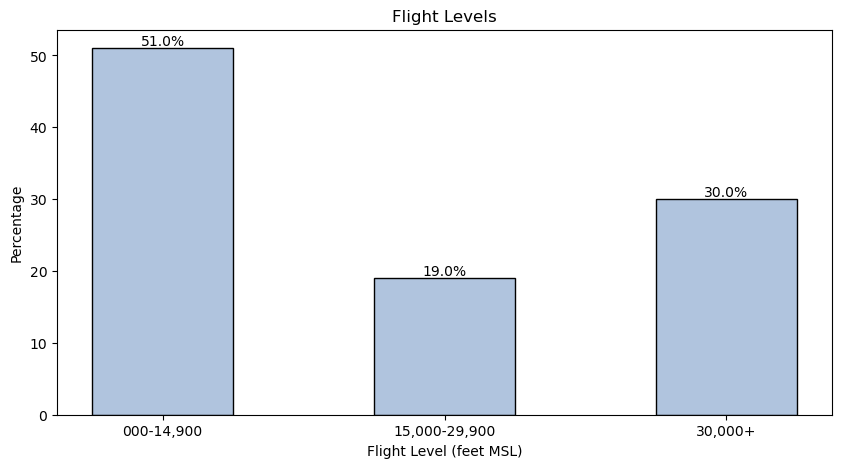

In [17]:
fl = [low, med, high]
level = ["000-14,900", "15,000-29,900", "30,000+"]

percent = [(num/new_tot)*100 for num in fl]
#print(percent)

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
fl_bar = plt.bar(level, percent, color ='lightsteelblue', ec="black", width = 0.5)

# for i in range(len(fl)):
#     plt.text(i,i, "{:.2f}".format(percent[i]), ha="center", va="bottom", fontsize=12)

for rect in fl_bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.1f}' "%", ha='center', va='bottom')

plt.xlabel("Flight Level (feet MSL)")
plt.ylabel("Percentage")
plt.title("Flight Levels")
plt.show()

#### Turbulence Reports Gridded - CONUS, AK, and HI

This section is to show the density of PIREPs over the continguous US (CONUS), Hawaii, and Alaska.

In [12]:
#path = './pirep_downloads/'

pirep_lats = []
pirep_lons = []

#df1 = pd.read_csv(path + 'all_pireps.csv', dtype=str, usecols = ['LAT', 'LON'])

pirep_lons = df.LON
pirep_lats = df.LAT

test_lats = np.array(pirep_lats.values, dtype='float')
test_lons = np.array(pirep_lons.values, dtype='float')

In [13]:
xbins_conus = np.arange(-129, 25.25, 0.5)
ybins_conus = np.arange(-66, 50.25, 0.5)

hist, x, y = np.histogram2d(test_lons, test_lats, bins=(xbins_conus, ybins_conus))

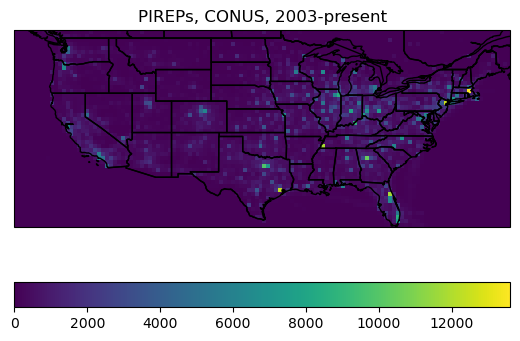

In [14]:
fig, ax = plt.subplots(subplot_kw = {'projection':ccrs.PlateCarree()})
ax.set_extent([-129,-66, 25, 50], crs=ccrs.PlateCarree())
cont = ax.pcolormesh(x, y, hist.transpose())
cb = fig.colorbar(cont, orientation='horizontal')

ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)

plt.title("PIREPs, CONUS, 2003-present")
plt.show()

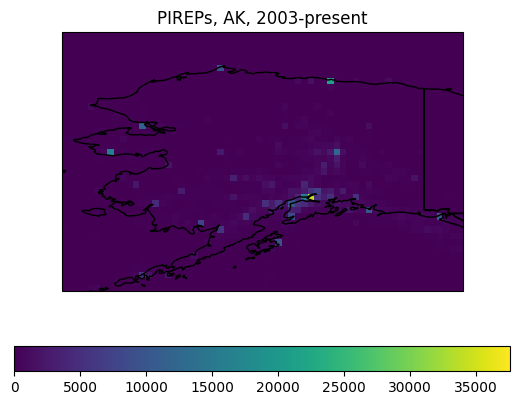

In [145]:
xbins_ak = np.arange(-169, 54.25, 0.5)
ybins_ak = np.arange(-138, 74.25, 0.5)

hist, x, y = np.histogram2d(test_lons, test_lats, bins=(xbins_ak, ybins_ak))

fig, ax = plt.subplots(subplot_kw = {'projection':ccrs.PlateCarree()})
ax.set_extent([-169,-138, 54, 74], crs=ccrs.PlateCarree())
cont = ax.pcolormesh(x, y, hist.transpose())
cb = fig.colorbar(cont, orientation='horizontal')

ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)

plt.title("PIREPs, AK, 2003-present")
plt.show()

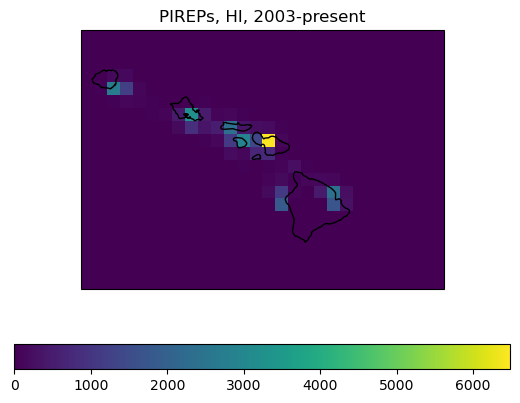

In [15]:
xbins_hi = np.arange(-160, 18.25, 0.25)
ybins_hi = np.arange(-153, 23.25, 0.25)

hist, x, y = np.histogram2d(test_lons, test_lats, bins=(xbins_hi, ybins_hi))

fig, ax = plt.subplots(subplot_kw = {'projection':ccrs.PlateCarree()})
ax.set_extent([-160,-153, 23, 18], crs=ccrs.PlateCarree())
cont = ax.pcolormesh(x, y, hist.transpose())
cb = fig.colorbar(cont, orientation='horizontal')

ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)

plt.title("PIREPs, HI, 2003-present")
plt.show()

#### Density Map of PIREPs, Overlayed with Airport Locations

(redo with some of the updated data)

This map visualizes pilot report densities and aiport locations over CONUS from 2010-2020.

Data used:
- In a separate notebook, I downloaded and combined pilot reports that mention turbulence from 2010-2020. Source: https://mesonet.agron.iastate.edu/request/gis/pireps.php

- Aviation location source = https://geodata.bts.gov/datasets/usdot::aviation-facilities/explore?location=38.745586%2C-94.206325%2C4.88
    - there are currently just under 20,000 airport facilities within the US. Just for visualization and data purposes, we'll use the top 50 US airports, found here: https://www.bts.dot.gov/content/passengers-boarded-top-50-us-airports. (3 were not within CONUS, so 47).
    
- Shapefile of the United States.
    
- Maps were created using ArcMap.
- Number of data points used: 1137152

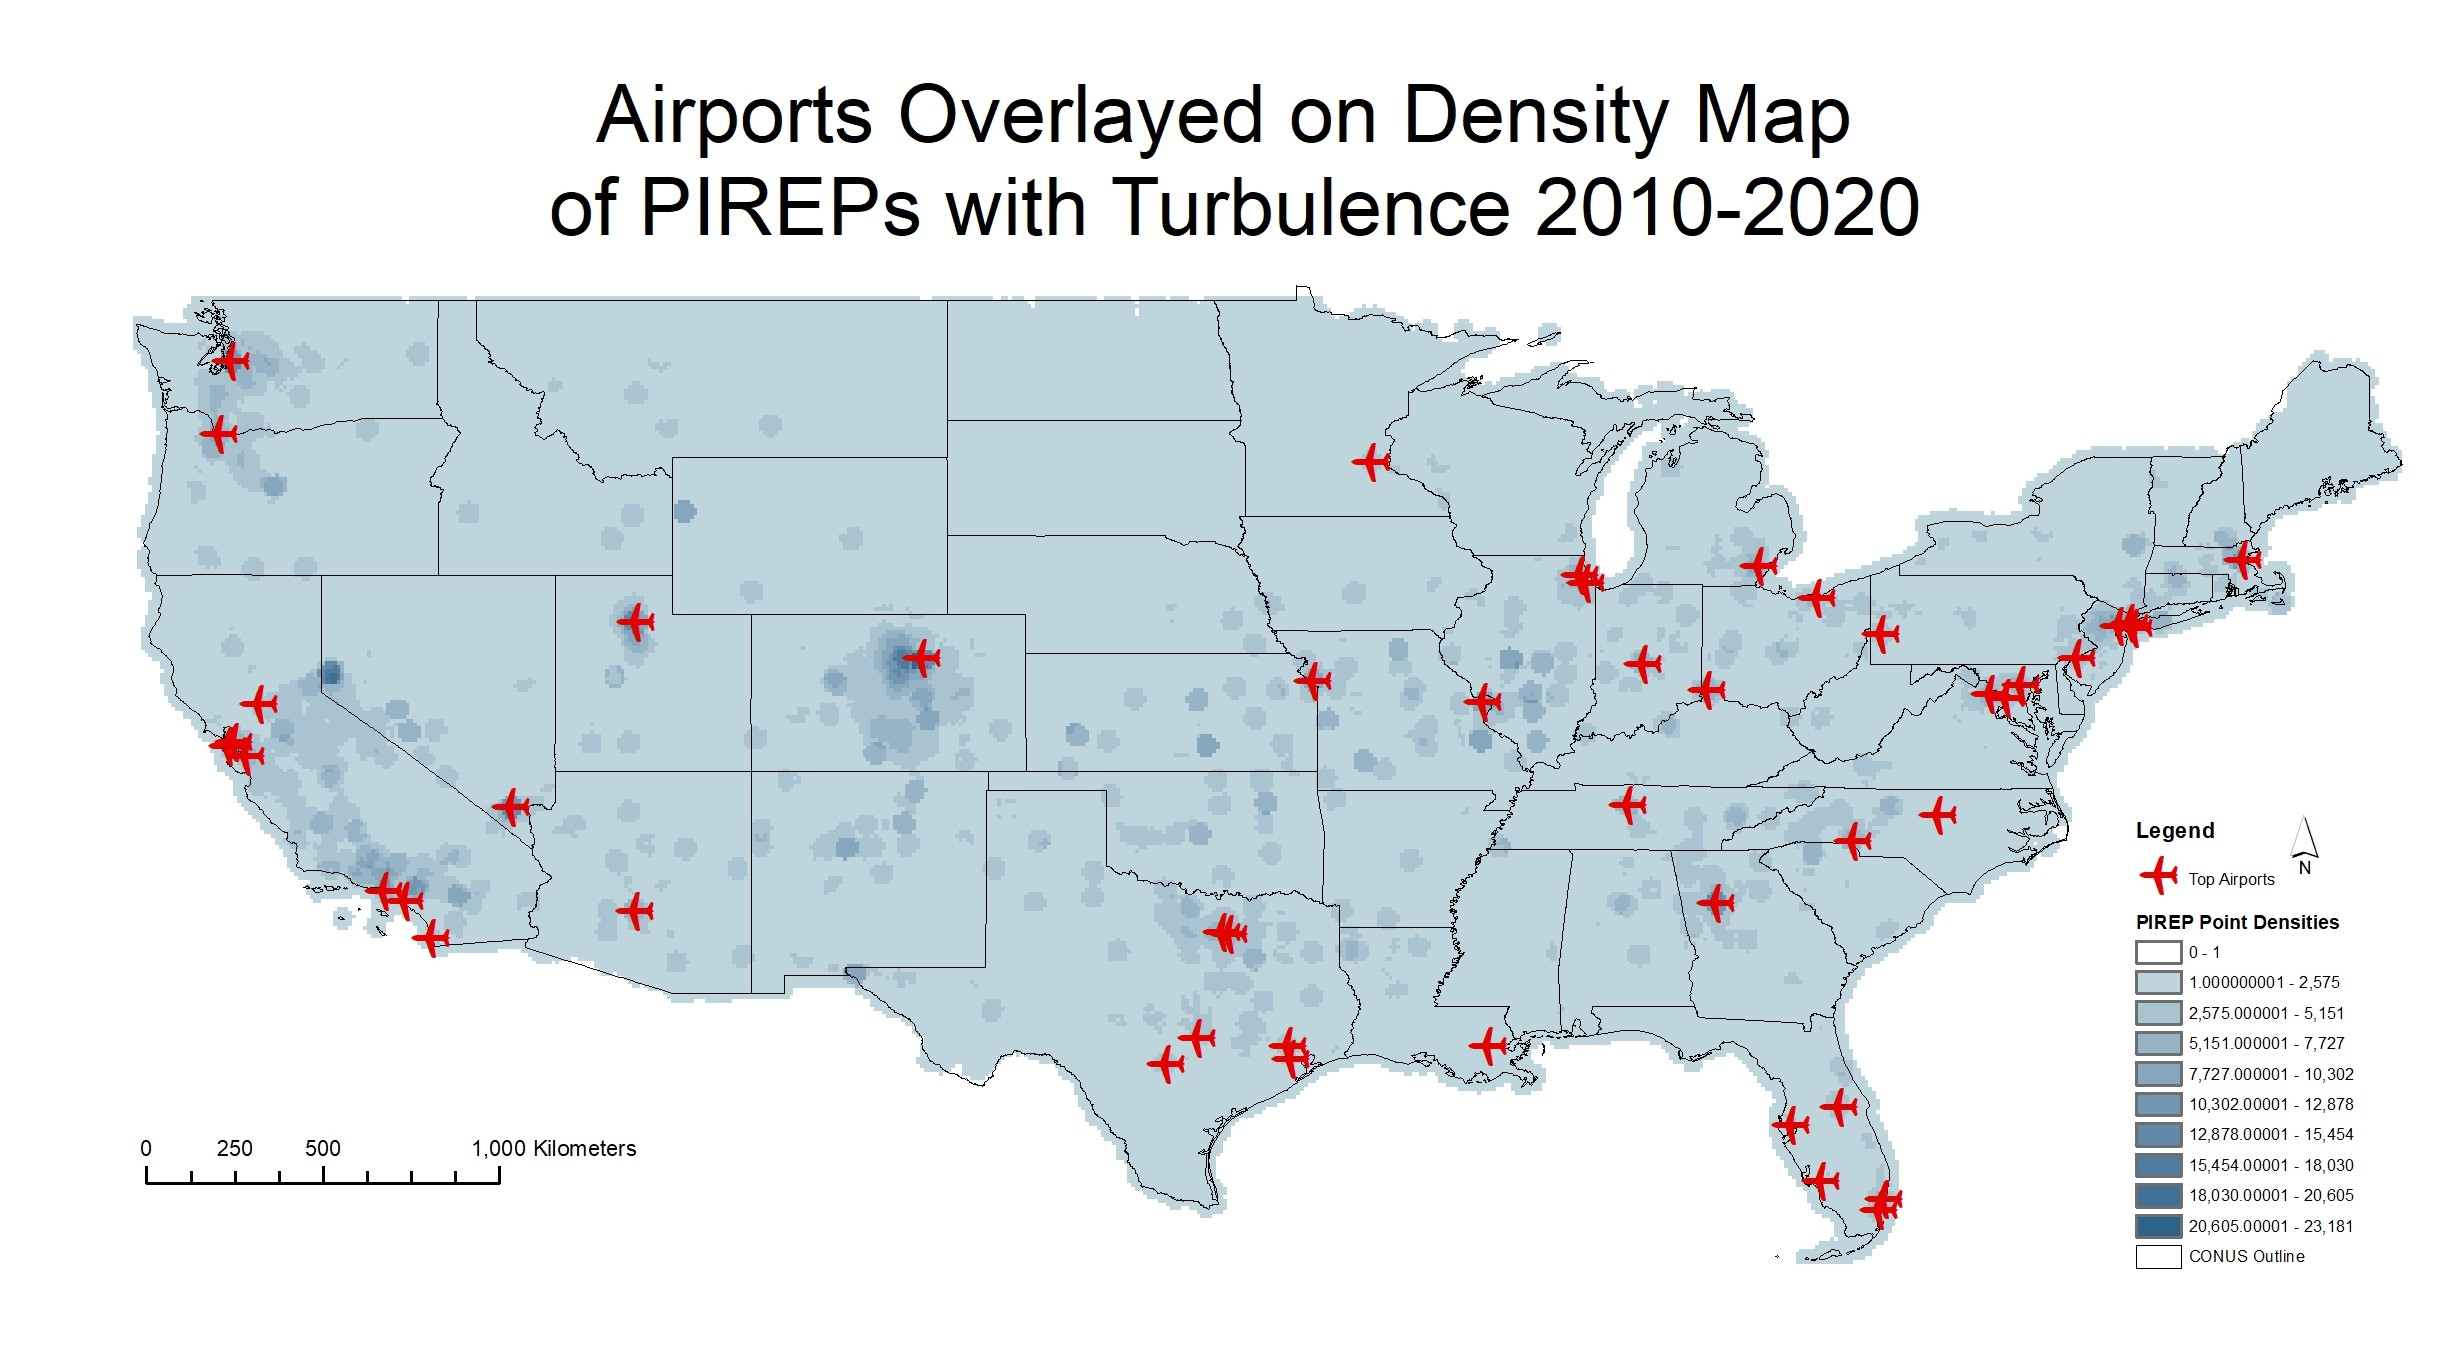

26.7% of PIREPs with turbulence were reported within 100km of the 47 major airports over CONUS


#### Density Map of PIREPs, Overlayed with Radar Sites

Similar to what we did above with a PIREP heatmap and airport sites, we'll plot a heatmap with radar sites. Inspiration for plotting this comes from here: https://www.weather.gov/media/publications/front/11nov-front.pdf (page 7). ATC relies on PIREPs in those areas that receive very poor radar coverage.

*would still be interested in doing this, just a side thing I was interested in looking at, but doesn't need to be completed for EDA

## Levels of Turbulence

This section is on levels of turbulence. Turbulence generally falls under none or smooth, light, moderate, severe, and extreme. There is also "Clear Air Turbulence", or CAT, which isn't necessarily a level, but is a type of turbulence (typically not marked by cumuliform clouds).

We'll also create a new column to assign a value to the max level of turbulence reported called "Intensity".

This can be subject to change, but we'll consider "-1" for unknown (some strings are quite different and may not have the usual smooth/light/moderate/severe/extreme or one of their variations), 0 for none/smooth, 1 for light, 2 for moderate, 3 for severe, and 4 for extreme. Note that because we are assigning max values, a report of "LGT-MOD" will be assigned 2 for moderate.

In [26]:
turb = df['TURBULENCE']
turb_int = []
df['Intensity'] = ''
for i in turb:
    if type(i) != str:
        turb_int.append(-1)
    elif "SMOOTH" in i or "SMTH" in i or "NONE" in i or "NEG" in i:
        turb_int.append(0)
    elif ("LGT" in i or "LIGHT" in i or "LT" in i):# and "M" not in i:
        turb_int.append(1)
    elif ("MOD" in i or "MDT" in i) and "S" not in i and "X" not in i:
        turb_int.append(2)
    elif ("SVR" in i or "SEV" in i or "SEVERE" in i) and 'X' not in i:
        turb_int.append(3)
    elif "EXT" in i or "EXTREME" in i:
        turb_int.append(4)
    else:
        turb_int.append(-1)

df['Intensity'] = turb_int
df[1:20]

,VALID,REPORT,TURBULENCE,LAT,LON,DateTime,FlightLevels,Intensity
1,201903010000,LFT UA /OV LFT180020 /TM 0000 /FL140 /TP E145 ...,NaN,29.87813966663967,-91.981,2019-03-01 00:00:00,140,-1
2,201903010000,LFT UA /OV LFT180020 /TM 0000 /FL140 /TP E145 ...,NaN,29.87813966663967,-91.981,2019-03-01 00:00:00,140,-1
3,201903010000,CLL UA /OV CLL /TM 0000 /FL250 /TP B737 /TB MO...,MOD CHOP 250-210,30.58806,-96.36389,2019-03-01 00:00:00,250,2
4,201903010000,CLL UA /OV CLL /TM 0000 /FL250 /TP B737 /TB MO...,MOD CHOP 250-210,30.58806,-96.36389,2019-03-01 00:00:00,250,2
5,201903010000,SAT UA /OV KERV /TM 0000 /FL021 /TP UNKN /SK B...,NaN,29.97667,-99.08547,2019-03-01 00:00:00,21,-1
6,201903010000,SAT UA /OV KERV /TM 0000 /FL021 /TP UNKN /SK B...,NaN,29.97667,-99.08547,2019-03-01 00:00:00,21,-1
7,201903010000,JHM UA /OV CHAIN/TM 0000/FL049/TP C208/SK SCT0...,NaN,35.03528,-85.20381,2019-03-01 00:00:00,49,-1
8,201903010000,CSG UA /OV CSG 050010/TM 0000/FL45/TP E545/SK ...,NaN,32.623249945922495,-84.79079885750748,2019-03-01 00:00:00,45,-1
9,201903010001,CNO UA /OV CNO/TM 0001/FL025/TP C172/TB NEG/RM...,NEG,33.97528,-117.63611,2019-03-01 00:01:00,25,0
10,201903010002,LVS UA /OV FTI030025/TM 0002/FL410/TP B787/TB ...,LGT MTN WAVE +-12KT,36.02087314663012,-104.88356604470329,2019-03-01 00:02:00,410,1


Let's pull numbers so we can make a bar chart:

In [27]:
smooth = df[df['Intensity'] == 0]
smooth = len(smooth)
light = df[df['Intensity'] == 1]
light = len(light)
mod = df[df['Intensity'] == 2]
mod = len(mod)
sev = df[df['Intensity'] == 3]
sev = len(sev)
ext = df[df['Intensity'] == 4]
ext = len(ext)
unk = df[df['Intensity'] == -1]
unk = len(unk)
total = total_num

print("none/smooth:", smooth, ",", "light:", light, ",", "mod:", mod, "severe:", sev, ",", "extreme:", ext, "unknown:", unk, "total reps:", total)

none/smooth: 186165 , light: 344756 , mod: 266105 severe: 17217 , extreme: 671 unknown: 1626445 total reps: 2824632


In [28]:
# getting percentages for each category
x = [smooth, light, mod, sev, ext, unk]
y = ["smooth or none", "light", "moderate", "severe", "extreme", "unknown"]

result = [(val/new_tot)*100 for val in x]
 
print(result)

[7.625465980218395, 14.121479061457165, 10.899871751757935, 0.7052219685838912, 0.02748469192773369, 66.62047654605489]


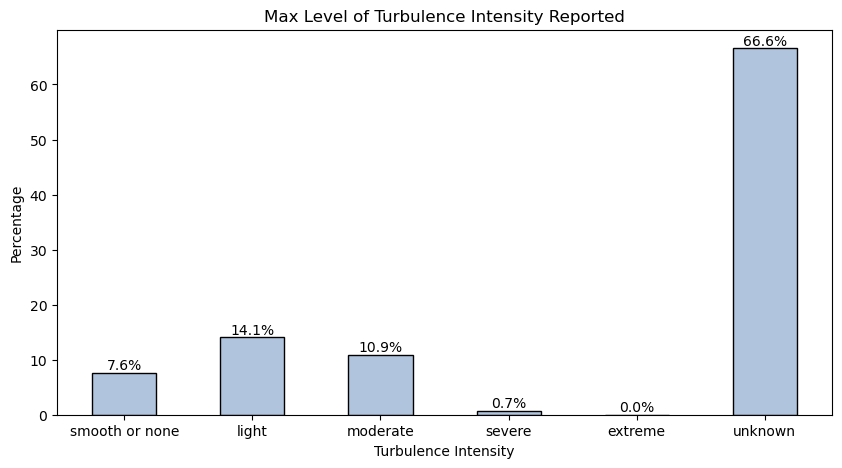

In [29]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
in_bar = plt.bar(y, result, color ='lightsteelblue', ec="black", width = 0.5)

for rect in in_bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.1f}' "%", ha='center', va='bottom')
 
plt.xlabel("Turbulence Intensity")
plt.ylabel("Percentage")
plt.title("Max Level of Turbulence Intensity Reported")
plt.show()
    
plt.show()

## Clear Air Turbulence

In case it's needed, we'll add a column indicating whether or not CAT was reported.

In [30]:
turb = df['TURBULENCE']
cat_pres = []
df['CAT?'] = ''

for i in turb:
    if "CAT" in i:
        cat_pres.append("True")
    else:
        cat_pres.append("False")

df['CAT?'] = cat_pres
df[1:10]

TypeError: argument of type 'float' is not iterable

CAT reported: 90783 , CAT not reported: 5913733
[1.5119120342089187, 98.48808796579108]


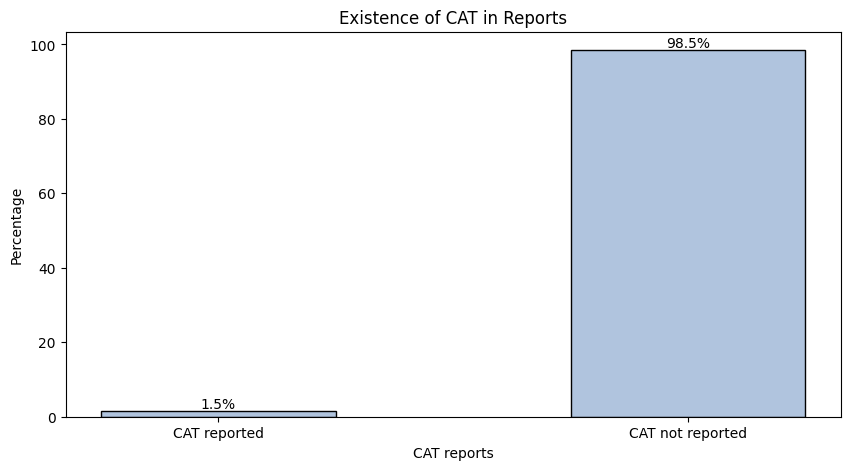

In [165]:
cat_p = df[df['CAT?'] == "True"]
cat_p = len(cat_p)
cat_n = df[df['CAT?'] == "False"]
cat_n = len(cat_n)

print("CAT reported:", cat_p, ",", "CAT not reported:", cat_n)

# getting percentages for each category
x = [cat_p, cat_n]
y = ["CAT reported", "CAT not reported"]

cat_res = [(val/new_tot)*100 for val in x]
 
print(cat_res)

# bar chart
fig = plt.figure(figsize = (10, 5))
 
cat_bar = plt.bar(y, cat_res, color ='lightsteelblue', ec="black", width = 0.5)

for rect in cat_bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.1f}' "%", ha='center', va='bottom')
 
plt.xlabel("CAT reports")
plt.ylabel("Percentage")
plt.title("Existence of CAT in Reports")
plt.show()

## Other Columns Needed

Let's add any other columns we can use for pre-processing. We'll need one to convert "DateTime" to decimal hours.

In [31]:
# decimal hours
dec_hrs = []
df['Dec_hr'] = ''
date = df["DateTime"]

for t in date:
    dec_hr = t.hour + (t.minute/60) 
    #print(dec_hr)
    dec_hrs.append(dec_hr)

df['Dec_hr'] = dec_hrs
df[1:10]

,VALID,REPORT,TURBULENCE,LAT,LON,DateTime,FlightLevels,Intensity,CAT?,Dec_hr
1,201903010000,LFT UA /OV LFT180020 /TM 0000 /FL140 /TP E145 ...,NaN,29.87813966663967,-91.981,2019-03-01 00:00:00,140,-1,,0.000000
2,201903010000,LFT UA /OV LFT180020 /TM 0000 /FL140 /TP E145 ...,NaN,29.87813966663967,-91.981,2019-03-01 00:00:00,140,-1,,0.000000
3,201903010000,CLL UA /OV CLL /TM 0000 /FL250 /TP B737 /TB MO...,MOD CHOP 250-210,30.58806,-96.36389,2019-03-01 00:00:00,250,2,,0.000000
4,201903010000,CLL UA /OV CLL /TM 0000 /FL250 /TP B737 /TB MO...,MOD CHOP 250-210,30.58806,-96.36389,2019-03-01 00:00:00,250,2,,0.000000
5,201903010000,SAT UA /OV KERV /TM 0000 /FL021 /TP UNKN /SK B...,NaN,29.97667,-99.08547,2019-03-01 00:00:00,21,-1,,0.000000
6,201903010000,SAT UA /OV KERV /TM 0000 /FL021 /TP UNKN /SK B...,NaN,29.97667,-99.08547,2019-03-01 00:00:00,21,-1,,0.000000
7,201903010000,JHM UA /OV CHAIN/TM 0000/FL049/TP C208/SK SCT0...,NaN,35.03528,-85.20381,2019-03-01 00:00:00,49,-1,,0.000000
8,201903010000,CSG UA /OV CSG 050010/TM 0000/FL45/TP E545/SK ...,NaN,32.623249945922495,-84.79079885750748,2019-03-01 00:00:00,45,-1,,0.000000
9,201903010001,CNO UA /OV CNO/TM 0001/FL025/TP C172/TB NEG/RM...,NEG,33.97528,-117.63611,2019-03-01 00:01:00,25,0,,0.016667


## Downloads

In [32]:
# csv with all points minus FL outliers and unknowns
dataDir = './updated_CSVs'
output_dir = Path('./updated_CSVs')

# check if directory exists -> if directory doesn't exist, directory is created
if not os.path.exists(dataDir):
    os.mkdir(dataDir)
    
# download 
df.to_csv(output_dir / "csv_fl_rem.csv")
print("Downloaded")

Downloaded


In [33]:
# download each flight level dataframe to a csv

# low
low = df[(df['FlightLevels'] >= 0o000) & (df['FlightLevels'] <= 149)]
low.to_csv(output_dir / "low_fl.csv")
print("Downloaded low")

# med
med = df[(df['FlightLevels'] >= 150) & (df['FlightLevels'] <= 299)]
med.to_csv(output_dir / "med_fl.csv")
print("Downloaded medium")

# high
high = df[(df['FlightLevels'] >= 300)]
high.to_csv(output_dir / "high_fl.csv")
print("Downloaded high")

Downloaded low
Downloaded medium
Downloaded high
